In [30]:
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchviz import make_dot
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline

In [31]:
# strength and range parameter of potential
eps,sig = 1.0,1.5

In [32]:
def Ulj(rs):
    f6 = (sig / rs) ** 6
    return 4*eps*(f6*f6  - f6)

In [33]:
base = torch.linspace(0.0, 4*sig,1000, requires_grad=True)
xs = base / sig
ps = Ulj(xs)/eps
loss = ps.sum()
loss.backward()
dps = base.grad / eps

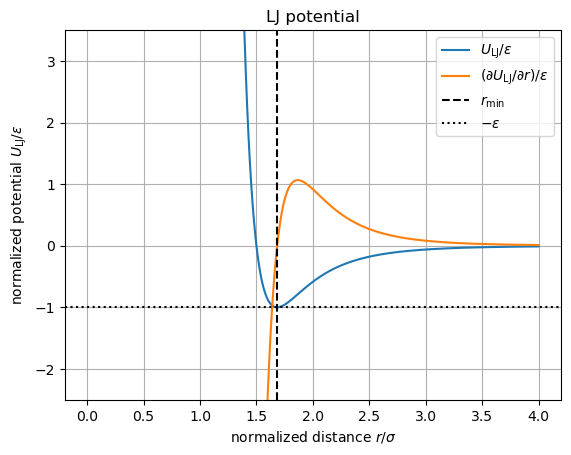

In [136]:
with torch.no_grad():
    plt.plot(xs,ps,label="$U_\\mathrm{LJ}/\\varepsilon$")
    plt.plot(xs,dps,label="$(\\partial U_\\mathrm{LJ}/\\partial r)/\\varepsilon$")
plt.ylim(-2.5,3.5)
plt.grid(True)
plt.title("LJ potential")
plt.xlabel("normalized distance $r/\\sigma$")
plt.ylabel("normalized potential $U_\\mathrm{LJ}/\\varepsilon$")
r_min = (2 ** (1/6)) * sig
plt.axvline(r_min, color="k", linestyle="--", label="$r_\\mathrm{min}$")
plt.axhline(-eps, color="k", linestyle=":", label="$-\\varepsilon$")
plt.legend()

### Calculating forces

Calculate the force between two particles at positions $r_1$ and $r_2$ like this: $\text{F}=-\frac{\partial U_\text{LJ}}{\partial r}$ where $r$ is the euclidean distance between the two particles.

In [137]:
dt = 1e-6
epochs, subepochs = 100, 2000
total_epochs = epochs*subepochs
m = 1.0 # particle mass

In [138]:
rs = torch.tensor([[-1.0,0.0],[1.0,0.0],[0.0,-1.0],[0.0,1.0]], requires_grad=True)
vs = torch.tensor([[10.0*sig,0.0],[-10.0*sig,0.0],[0.0,5.0*sig],[0.0,-5.0*sig]])
rs,vs

(tensor([[-1.,  0.],
         [ 1.,  0.],
         [ 0., -1.],
         [ 0.,  1.]], requires_grad=True),
 tensor([[ 15.0000,   0.0000],
         [-15.0000,   0.0000],
         [  0.0000,   7.5000],
         [  0.0000,  -7.5000]]))

In [139]:
# pairwise distances
dr = rs[None,:,:]-rs[:,None,:]

In [140]:
K = lambda v: 0.5*m*(F.norm(v, p=2.0, dim=1)**2)
with torch.no_grad():
    dists = F.norm(rs[None,:,:] - rs[:,None,:], dim=-1)
    Ks,Us = [K(vs).sum()], [Ulj(F.norm(dists, p=2.0)).item()]
    trajs = [(rs.clone(), vs.clone(), dists.clone())]
trajs

[(tensor([[-1.,  0.],
          [ 1.,  0.],
          [ 0., -1.],
          [ 0.,  1.]]),
  tensor([[ 15.0000,   0.0000],
          [-15.0000,   0.0000],
          [  0.0000,   7.5000],
          [  0.0000,  -7.5000]]),
  tensor([[0.0000, 2.0000, 1.4142, 1.4142],
          [2.0000, 0.0000, 1.4142, 1.4142],
          [1.4142, 1.4142, 0.0000, 2.0000],
          [1.4142, 1.4142, 2.0000, 0.0000]]))]

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]


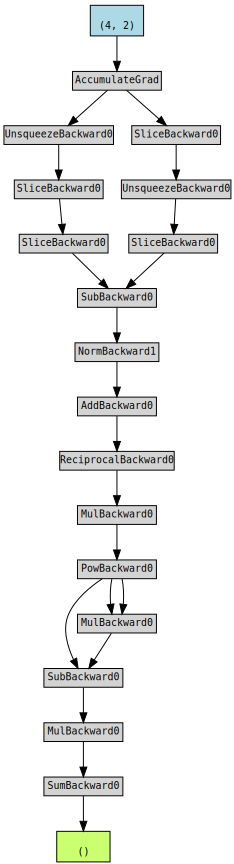

In [141]:
for epoch in tqdm(range(epochs)):
    for _ in range(subepochs):
        # calculate potential
        dr = rs[None,:,:] - rs[:,None,:]
        dists = F.norm(dr, dim=-1)
        # set diagonal distance entries to inf to make potential 0
        dists = dists + torch.diag(torch.inf * torch.ones(len(rs)))
        pot = Ulj(dists)
        potsum = pot.sum()
        
        # clear gradients and calc derivative
        rs.grad = None
        potsum.backward()
        # update particles
        with torch.no_grad():
            pot_F = -rs.grad
            a = pot_F/m
            
            # TODO: velocity verlet
            vs += dt*a
            rs += dt*vs# + 0.5*a1*(dt**2)
    with torch.no_grad():
        trajs.append((rs.clone(),vs.clone(),dists.clone()))
        Ks.append(K(vs).sum())
        Us.append(potsum.item())
make_dot(potsum)

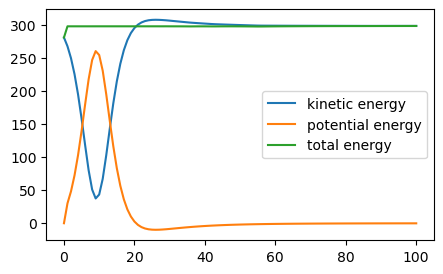

In [142]:
# show hockeystick diagram
fig,ax = plt.subplots(sharex=True,figsize=(5,3))
ax.plot(Ks, label="kinetic energy")
ax.plot(Us, label="potential energy")
ax.plot(torch.tensor(Ks)+torch.tensor(Us), label="total energy")
ax.legend()

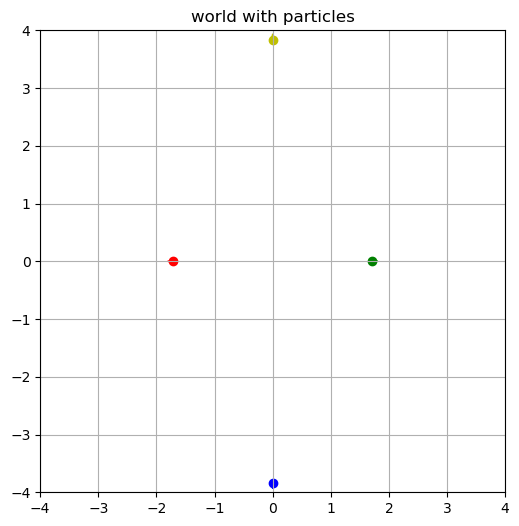

In [144]:
arrow_params = lambda c: dict(head_width=0.05, head_length=0.1, fc=c, ec=c, animated=True)

fig,ax = plt.subplots(figsize=(6,6))

# plot organization
ax.set_title("world with particles")
ax.grid(True)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

# store trajectory images
frames = []
for r,v,_ in trajs:
    elems = []
    for i,c in enumerate(list("rgby")):
        elems += [
            ax.scatter(*r[i], label=f"p{i}", color=c, animated=True),
            ax.arrow(*r[i], *dt*v[i], label=f"p{i}'s speed vector", **arrow_params(c)),
        ]
    frames.append(elems)
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1500)
HTML(ani.to_html5_video())